In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle
import random
import cv2

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

np.random.seed(0)

In [67]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)

with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)

print(type(train_data))

x_train, y_train = train_data['features'], train_data['labels']
x_val, y_val = val_data['features'], val_data['labels']
x_test, y_test = test_data['features'], test_data['labels']



<class 'dict'>


In [68]:
print(x_train.shape)#34799 images 32*32 pixels with depth of 3
print(x_val.shape)
print(x_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [69]:
assert (x_train.shape[0] == y_train.shape[0]), 'The number of images is not equal to the number of labels'
assert (x_val.shape[0] == y_val.shape[0]), 'The number of images is not equal to the number of labels'
assert (x_test.shape[0] == y_test.shape[0]), 'The number of images is not equal to the number of labels'

assert(x_train.shape[1: ] == (32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'
assert(x_val.shape[1: ] == (32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'
assert(x_test.shape[1: ] == (32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'

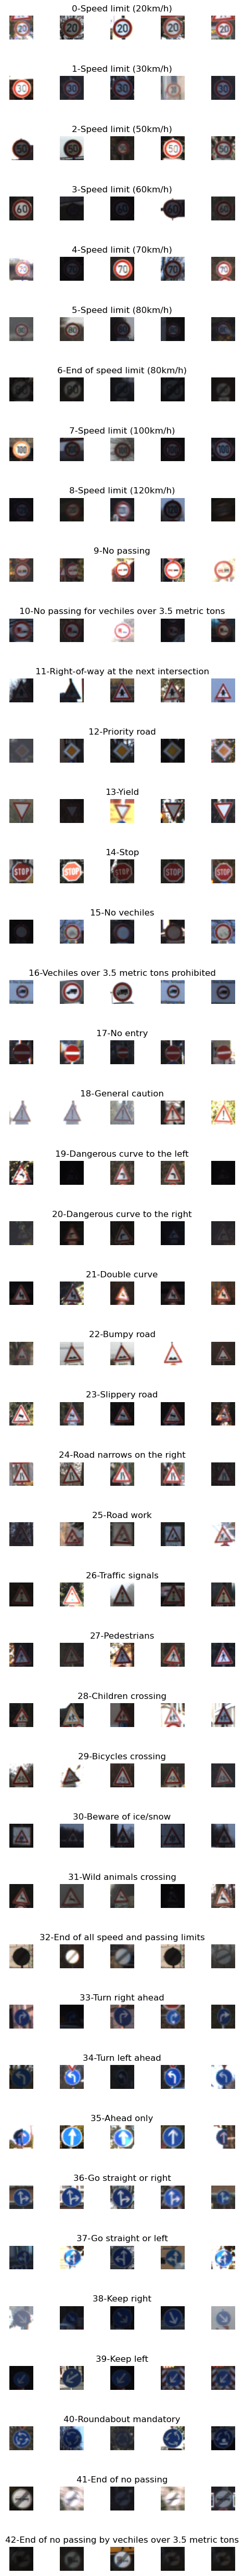

In [70]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = x_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ '-' + row['SignName'])
            num_of_samples.append(len(x_selected))


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

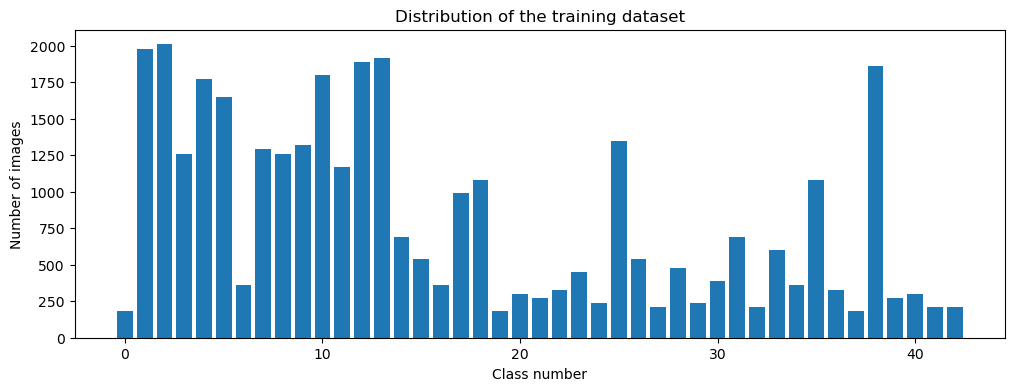

In [71]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")


(32, 32, 3)
36


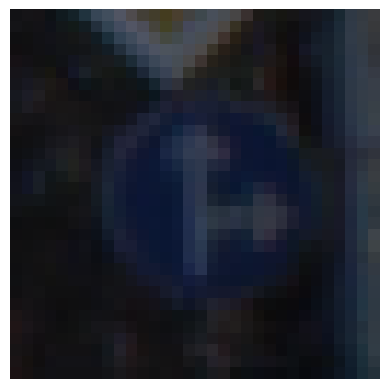

In [72]:
plt.imshow(x_train[1000], interpolation='none')
plt.axis('off')
print(x_train[1000].shape)
print(y_train[1000])

(32, 32)


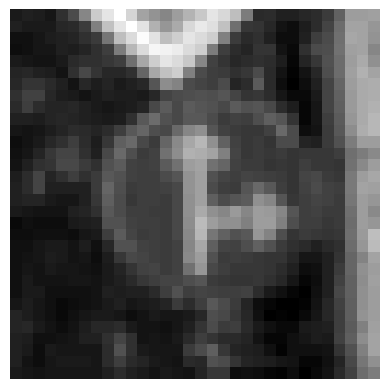

In [73]:
def gray_scale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = gray_scale(x_train[1000])
plt.imshow(img, cmap='gray', interpolation='none')
plt.axis('off')
print(img.shape)


(32, 32)


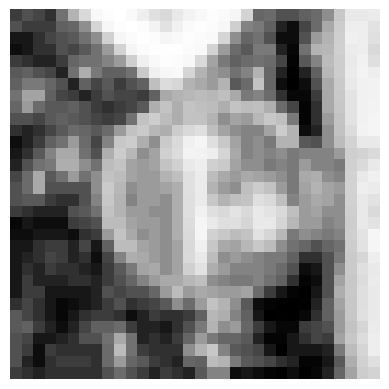

In [74]:
def equalize(img):#only accepts gray scale images
    img = cv2.equalizeHist(img)#only accepts gray scale images
    return img

img = equalize(gray_scale(x_train[1000]))
plt.imshow(img, cmap='gray', interpolation='none')
plt.axis('off')
print(img.shape)

In [75]:
def preprocessing(img):
    img = gray_scale(img)
    img = equalize(img)
    img = img/255
    return img

x_train = np.array(list(map(preprocessing, x_train)))
x_val = np.array(list(map(preprocessing, x_val)))
x_test = np.array(list(map(preprocessing, x_test)))


(34799, 32, 32)


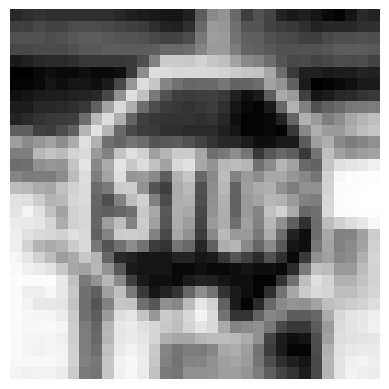

In [80]:
plt.imshow(x_train[random.randint(0, (len(x_train) - 1))], cmap='gray', interpolation='none')
plt.axis('off')
print(x_train.shape)

In [81]:
x_train = x_train.reshape(34799, 32, 32, 1)
x_val = x_val.reshape(4410, 32, 32, 1)
x_test = x_test.reshape(12630, 32, 32, 1)

In [82]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [83]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)